Table of Content 

Global Variables

1. Data Preprocessing

  1 Importing Data and Separating Data of Our Interest

  2 Creating Preprocessing Function and Applying it on Our Data

  3 Creating TF-IDF Matrix

2. Apply SVD to TF-IDF Matrix

  1 Create Term and Document Representation

  2 Visulize Those Representation

3. Information Retreival Using LSA

4. Create Model to Predict Recommendation

5. Train Autoencoder on TF-IDF Matrix

6. Information Retrieval Using Autoencoder

7. Predict Recommendation using Encoding of Autoencoder

8. Use simple NN to predict Recommendation

In [17]:
# Global Variables 
K = 2 # number of components


In [2]:
from google.colab import drive

In [4]:
#drive.mount('/content/drive')

In [5]:
# Importing Data and Separating Data of Our Interest 

import pandas as pd
import numpy as np

# Data filename
dataset_filename = "/content/drive/My Drive/edited_topics_set2.csv"

# Loading dataset
data = pd.read_csv(dataset_filename)



In [6]:
data.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern


In [22]:

# We are reducing the size of our dataset to decrease the running time of code
# list_of_clothing_id = data['Unnamed: 0'].value_counts()[:10].index
# y1 = [x == 0 for x in data['Recommended IND']]
# y2 = [x in list_of_clothing_id for x in data['Clothing ID']]
# y3 = [a or b for a,b in zip(y1,y2)]

datax = data[:100]


# # Delete missing observations for variables that we will be working with
# for x in ["Recommended IND","Review Text"]:
#     datax = datax[datax[x].notnull()]

# # Keeping only those features that we will explore
# datax = datax[["Recommended IND","Review Text"]]

# Resetting the index
datax.index = pd.Series(list(range(datax.shape[0])))
    
print('Shape : ',datax.shape)
datax.head()

Shape :  (100, 7)


,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern


In [15]:
# Creating Preprocessing Function and Applying it on Our Data 

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# datax['Processed Review'] = datax['Review Text'].apply(preprocess)

# datax.head()

In [23]:
# Creating TF-IDF Matrix 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
TF_IDF_matrix = vectorizer.fit_transform(datax['processed_content'])
TF_IDF_matrix = TF_IDF_matrix.T

print('Vocabulary Size : ', len(vectorizer.get_feature_names()))
print('Shape of Matrix : ', TF_IDF_matrix.shape)

Vocabulary Size :  4410
Shape of Matrix :  (4410, 100)


In [24]:
#Apply SVD to TF-IDF Matrix 
#Create Term and Document Representation 
# import numpy as np

# # Applying SVD
# U, s, VT = np.linalg.svd(TF_IDF_matrix.toarray()) # .T is used to take transpose and .toarray() is used to convert sparse matrix to normal matrix

# TF_IDF_matrix_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), VT[:K, :]))

# # Getting document and term representation
# terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # M X K matrix where M = Vocabulary Size and N = Number of documents
# docs_rep = np.dot(np.diag(s[:K]), VT[:K, :]).T # N x K matrix 
import numpy as np
from scipy.sparse.linalg import svds

# Applying SVD
U, s, VT = svds(TF_IDF_matrix) # .T is used to take transpose and .toarray() is used to convert sparse matrix to normal matrix

TF_IDF_matrix_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), VT[:K, :]))

# Getting document and term representation
terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # M X K matrix where M = Vocabulary Size and N = Number of documents
docs_rep = np.dot(np.diag(s[:K]), VT[:K, :]).T # N x K matrix 

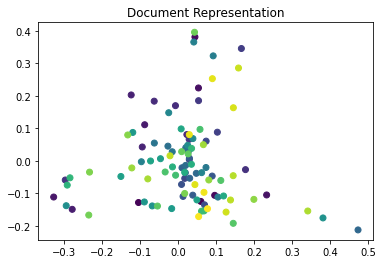

In [25]:
#Visulize Those Representation 
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep[:,0], docs_rep[:,1], c=datax['Unnamed: 0'])
plt.title("Document Representation")
plt.show()

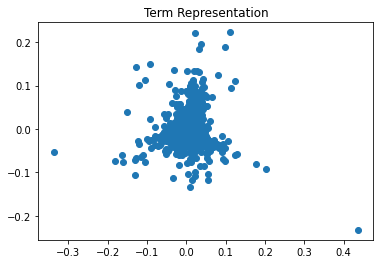

In [26]:
plt.scatter(terms_rep[:,0], terms_rep[:,1])
plt.title("Term Representation")
plt.show()

In [12]:
#Information Retreival Using LSA 
# This is a function to generate query_rep

def lsa_query_rep(query):
    query_rep = [vectorizer.vocabulary_[x] for x in preprocess(query).split()]
    query_rep = np.mean(terms_rep[query_rep],axis=0)
    return query_rep

In [28]:
query = 'good price'

In [29]:
from scipy.spatial.distance import cosine

query_rep = lsa_query_rep(query)

query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))

print_count = 0
for rank, sort_index in enumerate(query_doc_sort_index):
    print ('Rank : ', rank, ' Consine : ', 1 - query_doc_cos_dist[sort_index],' Review : ', datax['processed_content'][sort_index])
    if print_count == 4 :
        break
    else:
        print_count += 1

Rank :  0  Consine :  0.9979722032077559  Review :  market regul sebi look permit futur trade petrol diesel offici say emphasis disrupt commod deriv trade covid crisi secur exchang board india sebi look allow futur trade urad ban spike price commod product mention urad weather indic includ petrol diesel look sebi general manag commod segment chhavi kapoor say webinar host chamber commerc industri phdcci add product pipelin give market condit product look product come current futur trade allow crude petrol diesel major refineri product deriv crude earlier industri demand allow futur trade petroleum product sebi send propos petroleum ministri issu phdcci presid aggarw say sensit issu know sebi ministri comfort say price petrol diesel india affect local tax compris cent total cost suppos retail price diesel litr cost tax come product affect industri entir economi think allow product help hedg price market particip like product add earlier respond queri make corpor hedg compulsori commod d

In [32]:
#Create Model to Predict Recommendation 
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

def create_logistic_model(X,y):
    
    # Splitting data for training and validation
    x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(X),y,test_size=0.1, random_state=1)
    
    # Getting the input dimension
    input_dim = X.shape[1]
    
    # this is our input placeholder
    input_doc = Input(shape=(input_dim,))
    # This is dense layer
    dense_layer = Dense(1, activation='sigmoid')(input_doc)
    # Our final model
    model = Model(input_doc, dense_layer)
    
    # Compiling model
    model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
    
    
    # Training model
    history = model.fit(x_train, y_train,
                epochs=5,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, y_test),
                verbose=0)
    # Printing Accuracy
    print('Accuracy on Training Data : ', history.history['accuracy'][-1])
    print('Accuracy on Validation Data : ', history.history['val_accuracy'][-1])
    
    # Returning model
    return model, history

In [33]:
model_using_lsa, history = create_logistic_model(docs_rep, datax['Unnamed: 0'])

Accuracy on Training Data :  0.011111111380159855
Accuracy on Validation Data :  0.0


In [34]:
datax['Unnamed: 0'].value_counts() / datax['Unnamed: 0'].shape[0]

99    0.01
36    0.01
26    0.01
27    0.01
28    0.01
      ... 
69    0.01
70    0.01
71    0.01
72    0.01
0     0.01
Name: Unnamed: 0, Length: 100, dtype: float64

In [35]:
print(np.sum(model_using_lsa.predict(docs_rep) > .5))
print(docs_rep.shape[0])

100
100


In [36]:
#IR using Autoencoder with TF-IDF matrix 

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 2 # Size of encoding
input_dim = TF_IDF_matrix.shape[0] # Size of docs

# Splitting Data for training and validation
df = pd.DataFrame(TF_IDF_matrix.T.toarray())
x_train, x_val, y_train, y_val = train_test_split(df, df[0], test_size=0.1, random_state=1)

# Encoder and Decoder
# this is our input placeholder
input_docs = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_docs)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_docs, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_docs, encoded)

# create a placeholder for an encoded (2-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=(x_val, x_val))

# encode and decode some data points
print('Original Data : ', x_val[:5])
encoded_datapoints = encoder.predict(x_val[:5])
print('Encodings : ', encoded_datapoints)
decoded_datapoints = decoder.predict(encoded_datapoints)
print('Reconstructed Data : ', decoded_datapoints)

Original Data :          0     1     2     3     4     5     ...  4404  4405  4406  4407  4408  4409
80  0.074679   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
84  0.000000   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
33  0.000000   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
81  0.000000   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
93  0.000000   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 4410 columns]
Encodings :  [[-0.00630073  0.00481211]
 [-0.00911656  0.02744641]
 [ 0.00347392 -0.03427448]
 [ 0.0068997  -0.02896116]
 [ 0.02748939 -0.03555531]]
Reconstructed Data :  [[0.0000000e+00 5.0172159e-05 2.0395925e-04 ... 0.0000000e+00
  6.4987339e-06 1.6772329e-04]
 [0.0000000e+00 7.7162497e-04 1.0069733e-03 ... 4.6374873e-04
  0.0000000e+00 8.2239846e-04]
 [9.8874827e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0319002e-04 0.0000000e+00]
 [8.

In [37]:
docs_rep_autoencoder = encoder.predict(TF_IDF_matrix.T)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep_autoencoder[:,0], docs_rep_autoencoder[:,1], c=datax['Unnamed: 0'])
plt.title("Document Representation")
plt.show()

InvalidArgumentError: ignored

In [38]:
#Information Retreival Using Autoencoder 
# This is a function to generate query_rep
def autoencoder_query_rep(query):
    query_rep = vectorizer.transform([query])
    query_rep = encoder.predict(query_rep)
    return query_rep

In [39]:
from scipy.spatial.distance import cosine

query_rep = autoencoder_query_rep(query)

query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))

print_count = 0
for rank, sort_index in enumerate(query_doc_sort_index):
    print ('Rank : ', rank, ' Consine : ', 1 - query_doc_cos_dist[sort_index],' Review : ', datax['Review Text'][sort_index])
    if print_count == 4 :
        break
    else:
        print_count += 1

InvalidArgumentError: ignored

In [ ]:
#Predict Recommendation using Encoding of Autoencoder 
model_using_autoencoder, history = create_logistic_model(docs_rep_autoencoder, datax['Recommended IND'])

In [ ]:
datax['Recommended IND'].value_counts() / datax['Recommended IND'].shape[0]

In [ ]:
print(np.sum(model_using_lsa.predict(docs_rep) > .5))
print(docs_rep.shape[0])

In [ ]:
#Use simple NN to predict Recommendation 
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

input_dim = TF_IDF_matrix.shape[0] # Size of docs

# Splitting Data for training and validation
df = pd.DataFrame(TF_IDF_matrix.T.toarray())
x_train, x_val, y_train, y_val = train_test_split(df, datax['Recommended IND'], test_size=0.1, random_state=1)

# this is our input placeholder
input_docs = Input(shape=(input_dim,))
layer1 = Dense(100, activation='relu')(input_docs)
layer2 = Dense(10, activation='relu')(layer1)
layer3 = Dense(2, activation='relu')(layer2)
layer4 = Dense(1, activation='sigmoid')(layer3)

# Get encoding
encoder = Model(input_docs, layer3)

# Final Model
model = Model(input_docs, layer4)

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                epochs=125,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=(x_val, y_val))

# Printing Accuracy
print('Accuracy on Training Data : ', history.history['acc'][-1])
print('Accuracy on Validation Data : ', history.history['val_acc'][-1])

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Displaying all plot of encodings and saving these for report
docs_rep_nn = encoder.predict(TF_IDF_matrix.T)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep_nn[:,0], docs_rep_nn[:,1], c=datax['Recommended IND'])
plt.show()

plt.savefig('doc_rep_plot_nn.png')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep[:,0], docs_rep[:,1], c=datax['Recommended IND'])
plt.show()

plt.savefig('doc_rep_plot_lsa.png')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep_autoencoder[:,0], docs_rep_autoencoder[:,1], c=datax['Recommended IND'])
plt.show()

plt.savefig('doc_rep_plot_ae.png')